In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [15]:
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# src_path = os.path.join(project_root, "src")

if project_root not in sys.path:
    sys.path.append(project_root)

In [16]:
data_dir_path = os.path.join("..", "data", "gridloss", "train.csv")
df = pd.read_csv(data_dir_path, index_col=0)
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   demand                     17518 non-null  float64
 1   grid1-load                 17520 non-null  float64
 2   grid1-loss                 17519 non-null  float64
 3   grid1-loss-prophet-daily   16775 non-null  float64
 4   grid1-loss-prophet-pred    16775 non-null  float64
 5   grid1-loss-prophet-trend   16775 non-null  float64
 6   grid1-loss-prophet-weekly  16775 non-null  float64
 7   grid1-loss-prophet-yearly  16775 non-null  float64
 8   grid1-temp                 17518 non-null  float64
 9   grid2-load                 17520 non-null  float64
 10  grid2-loss                 17519 non-null  float64
 11  grid2-loss-prophet-daily   16775 non-null  float64
 12  grid2-loss-prophet-pred    16775 non-null  float64
 13  grid2-loss-

In [17]:
# Backfill missing data
df = df.bfill()

# print(df.isnull().sum())

In [18]:
from src.utils.generate_dataset import generate_windows_dataset

grid1_columns = ["grid1-load","grid1-loss","grid1-temp"]
window_size = 168 # 1 week
# step_size = 1 # 1 hour
# step_size = 24 # 1 day
# step_size = 48 # 2 day
step_size = 168 # 1 week
num_ts = len(grid1_columns)
dataset_size = (df.shape[0] - window_size)//step_size + 1
force_calc_windows: bool = True

windows_data_paths = [os.path.join("..", "data", "gridloss", "windows", f"ts{i}_w{window_size}_s{step_size}_n{dataset_size}.csv") for i in range(num_ts)]

load_windows: bool = all([os.path.exists(path) for path in windows_data_paths])
if not load_windows or force_calc_windows:
    print("Generating windows dataset")
    data = generate_windows_dataset(df, window_size, step_size, grid1_columns)
else:
    # TODO: Add datetime index to the windows that are saved/loaded
    print("Loading windows dataset")
    data_transposed = [pd.read_csv(path).to_numpy() for path in windows_data_paths]
    data = np.asarray(data_transposed).transpose(1, 2, 0).tolist()
    data = [pd.DataFrame(data[i], columns=grid1_columns) for i in range(len(data))]

print(type(data), np.asarray(data).shape)

Generating windows dataset


100%|██████████| 104/104 [00:00<00:00, 34666.42it/s]

<class 'list'> (104, 168, 3)


In [19]:
data[0].head() == df[grid1_columns].head()

,grid1-load,grid1-loss,grid1-temp
2017-12-01 00:00:00,True,True,True
2017-12-01 01:00:00,True,True,True
2017-12-01 02:00:00,True,True,True
2017-12-01 03:00:00,True,True,True
2017-12-01 04:00:00,True,True,True


In [20]:
# Save windows to file
data_transposed = np.asarray(data).transpose(2,0,1)

for i in range(num_ts):
    if not os.path.exists(windows_data_paths[i]):
        pd.DataFrame(data_transposed[i]).to_csv(windows_data_paths[i], index=False)

In [21]:
from src.utils.features import decomp_and_features

sp = 24 # STL parameter

features_paths = [os.path.join("..", "data", "gridloss", "features", f"features_ts{i}_w{window_size}_s{step_size}_n{dataset_size}.csv") for i in range(num_ts)]
load_features = all([os.path.exists(path) for path in features_paths])

# NOTE: Currently not using, saving or loading decompositions
if not load_features:
    # Calculate features
    decomps, features = decomp_and_features(data, series_periodicity=sp, dataset_size=dataset_size)
    print(np.asarray(decomps).shape, features.shape)
else:
    # Load features from file
    features_transposed = [pd.read_csv(path).to_numpy() for path in features_paths]
    features = np.asarray(features_transposed).transpose(1, 0, 2)
    print(features.shape)

(104, 3, 4)


In [22]:
# Save features to file
features_paths = [os.path.join("..", "data", "gridloss", "features", f"features_ts{i}_w{window_size}_s{step_size}_n{dataset_size}.csv") for i in range(num_ts)]

for i in range(num_ts):
    if not os.path.exists(features_paths[i]):
        pd.DataFrame(features[:,i]).to_csv(features_paths[i], index=False)

In [23]:
from sklearn.decomposition import PCA
print(features.shape)
mts_features_reshape = features.reshape((features.shape[0], features.shape[1]*features.shape[2]))
print(mts_features_reshape.shape)

pca_2d = PCA(n_components=2)
mts_pca_2d = pca_2d.fit_transform(mts_features_reshape)

(104, 3, 4)
(104, 12)


In [24]:
mts_pca_df = pd.DataFrame(data=mts_pca_2d, columns=["pca1", "pca2"])
mts_pca_df['index'] = mts_pca_df.index

In [25]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [26]:
fig = px.scatter(mts_pca_df, x='pca1', y='pca2', hover_data=['index'])
fig.show()

In [27]:
mts_index = 24

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Line(x=data[mts_index].index, y=data[mts_index]["grid1-load"], name="grid1-load"), row=1, col=1)
fig.add_trace(go.Line(x=data[mts_index].index, y=data[mts_index]["grid1-loss"], name="grid1-loss"), row=2, col=1)
fig.add_trace(go.Line(x=data[mts_index].index, y=data[mts_index]["grid1-temp"], name="grid1-temp"), row=3, col=1)

fig.update_layout(height=600, width=800, title_text=f"MTS index {mts_index}")

fig.show()


c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




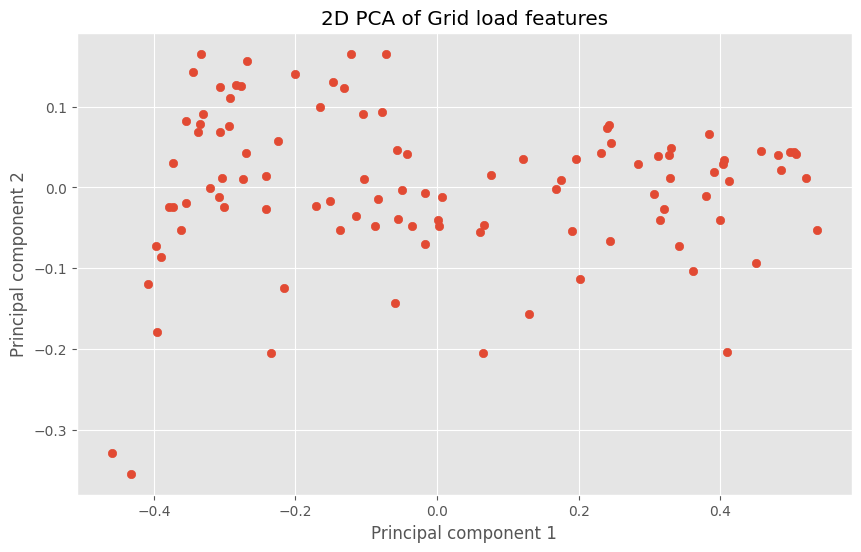

In [28]:
ts1_features_reshape = mts_features_reshape[:,0:4]

pca_2d = PCA(n_components=2)
ts1_pca_2d = pca_2d.fit_transform(ts1_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts1_pca_2d[:, 0], ts1_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Grid load features')
plt.show()

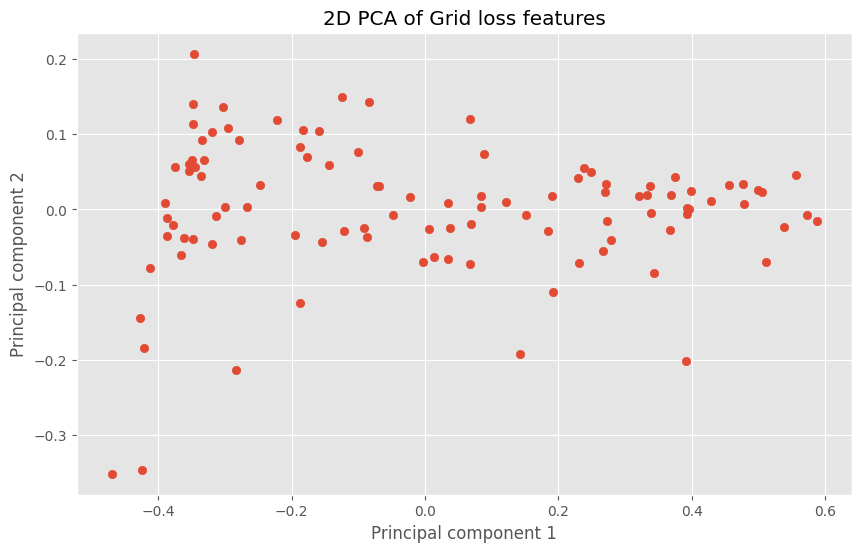

In [29]:
ts2_features_reshape = mts_features_reshape[:,4:8]

pca_2d = PCA(n_components=2)
ts2_pca_2d = pca_2d.fit_transform(ts2_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts2_pca_2d[:, 0], ts2_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Grid loss features')
plt.show()

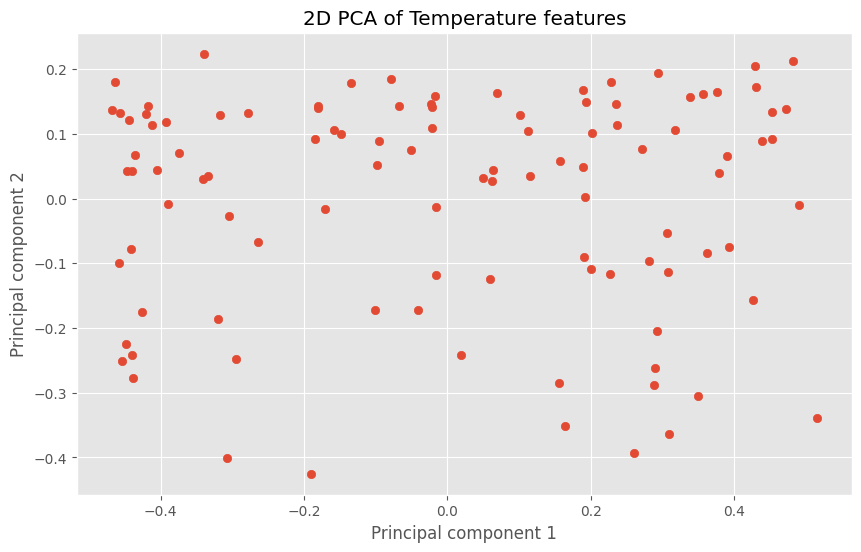

In [30]:
ts3_features_reshape = mts_features_reshape[:,8:12]

pca_2d = PCA(n_components=2)
ts3_pca_2d = pca_2d.fit_transform(ts3_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts3_pca_2d[:, 0], ts3_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Temperature features')
plt.show()

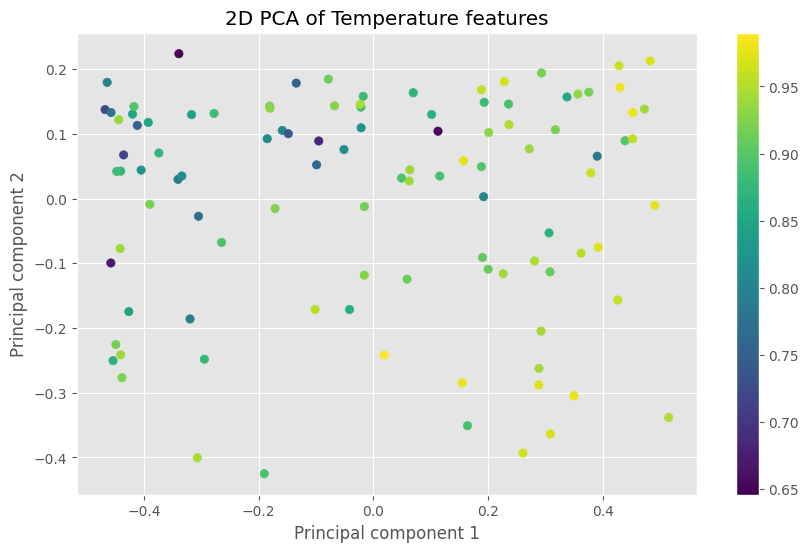

In [31]:
mts_pca = mts_pca_2d.copy()
uts_pca_list = [ts1_pca_2d, ts2_pca_2d, ts3_pca_2d]

plt.figure(figsize=(10, 6))
plt.scatter(ts3_pca_2d[:, 0], ts3_pca_2d[:, 1], c=mts_features_reshape[:,8])
plt.colorbar()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Temperature features')
plt.show()

In [32]:
def plot_feature_gradient_color(pca_2d, features_reshape, uts_pca_list, is_mts=False):
    feature_names = ["TREND DET", "TREND SLOPE", "TREND LIN", "SEASONAL DET"]
    uts_names = ["grid1-load", "grid1-loss", "grid1-temp"]
    num_features = len(feature_names)
    num_ts = len(uts_names)
    fig, axes = plt.subplots(nrows=num_ts, ncols=num_features, figsize=(num_features*4, num_ts*4))
    for i in range(num_ts):
        for j in range(num_features):
            if is_mts:
                axes[i, j].scatter(pca_2d[:, 0], pca_2d[:, 1], c=features_reshape[:,i*4+j])
            else:
                axes[i, j].scatter(uts_pca_list[i][:, 0], uts_pca_list[i][:, 1], c=features_reshape[:,i*4+j])
            axes[i, j].set_xlabel('Principal component 1')
            axes[i, j].set_ylabel('Principal component 2')
            axes[i, j].set_title(f'Feature {feature_names[j]} in {uts_names[i]}')
    fig.tight_layout()
    fig.show()


C:\Users\hansj\AppData\Local\Temp\ipykernel_11160\3405413561.py:17: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



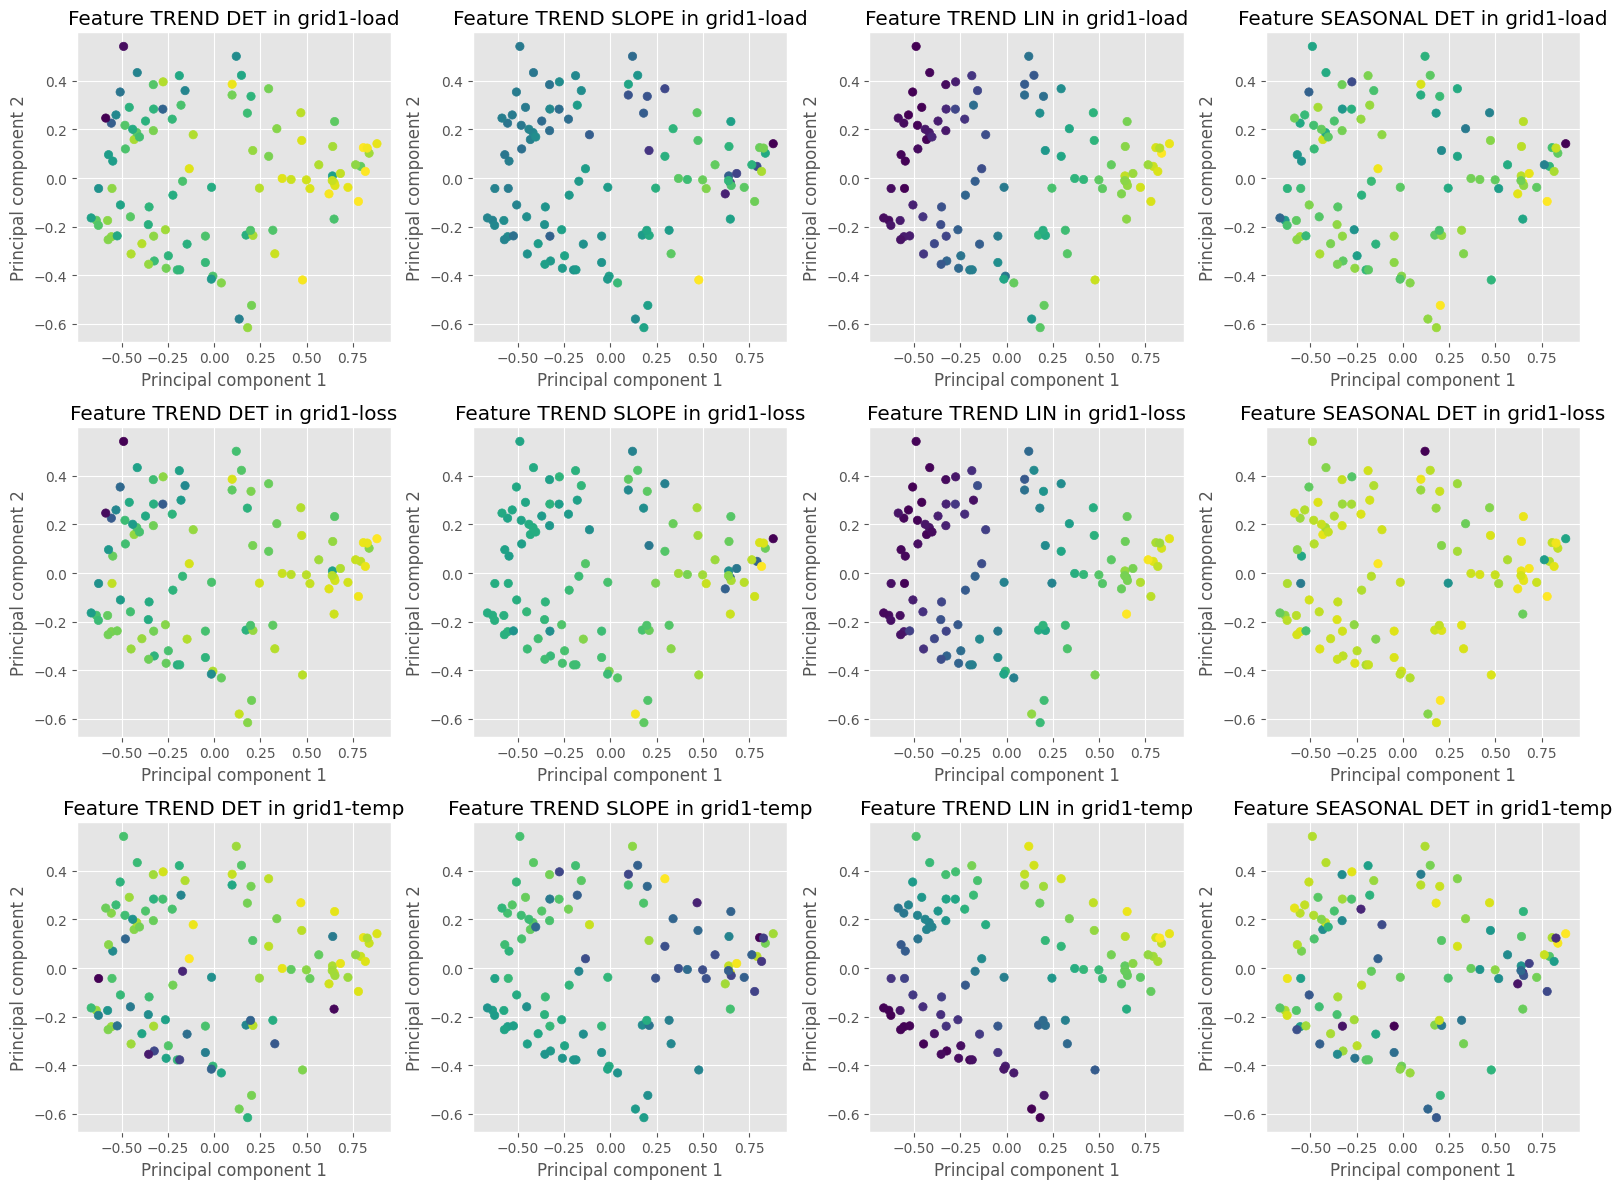

In [33]:
plot_feature_gradient_color(mts_pca, mts_features_reshape, uts_pca_list, is_mts=True)

C:\Users\hansj\AppData\Local\Temp\ipykernel_11160\3405413561.py:17: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



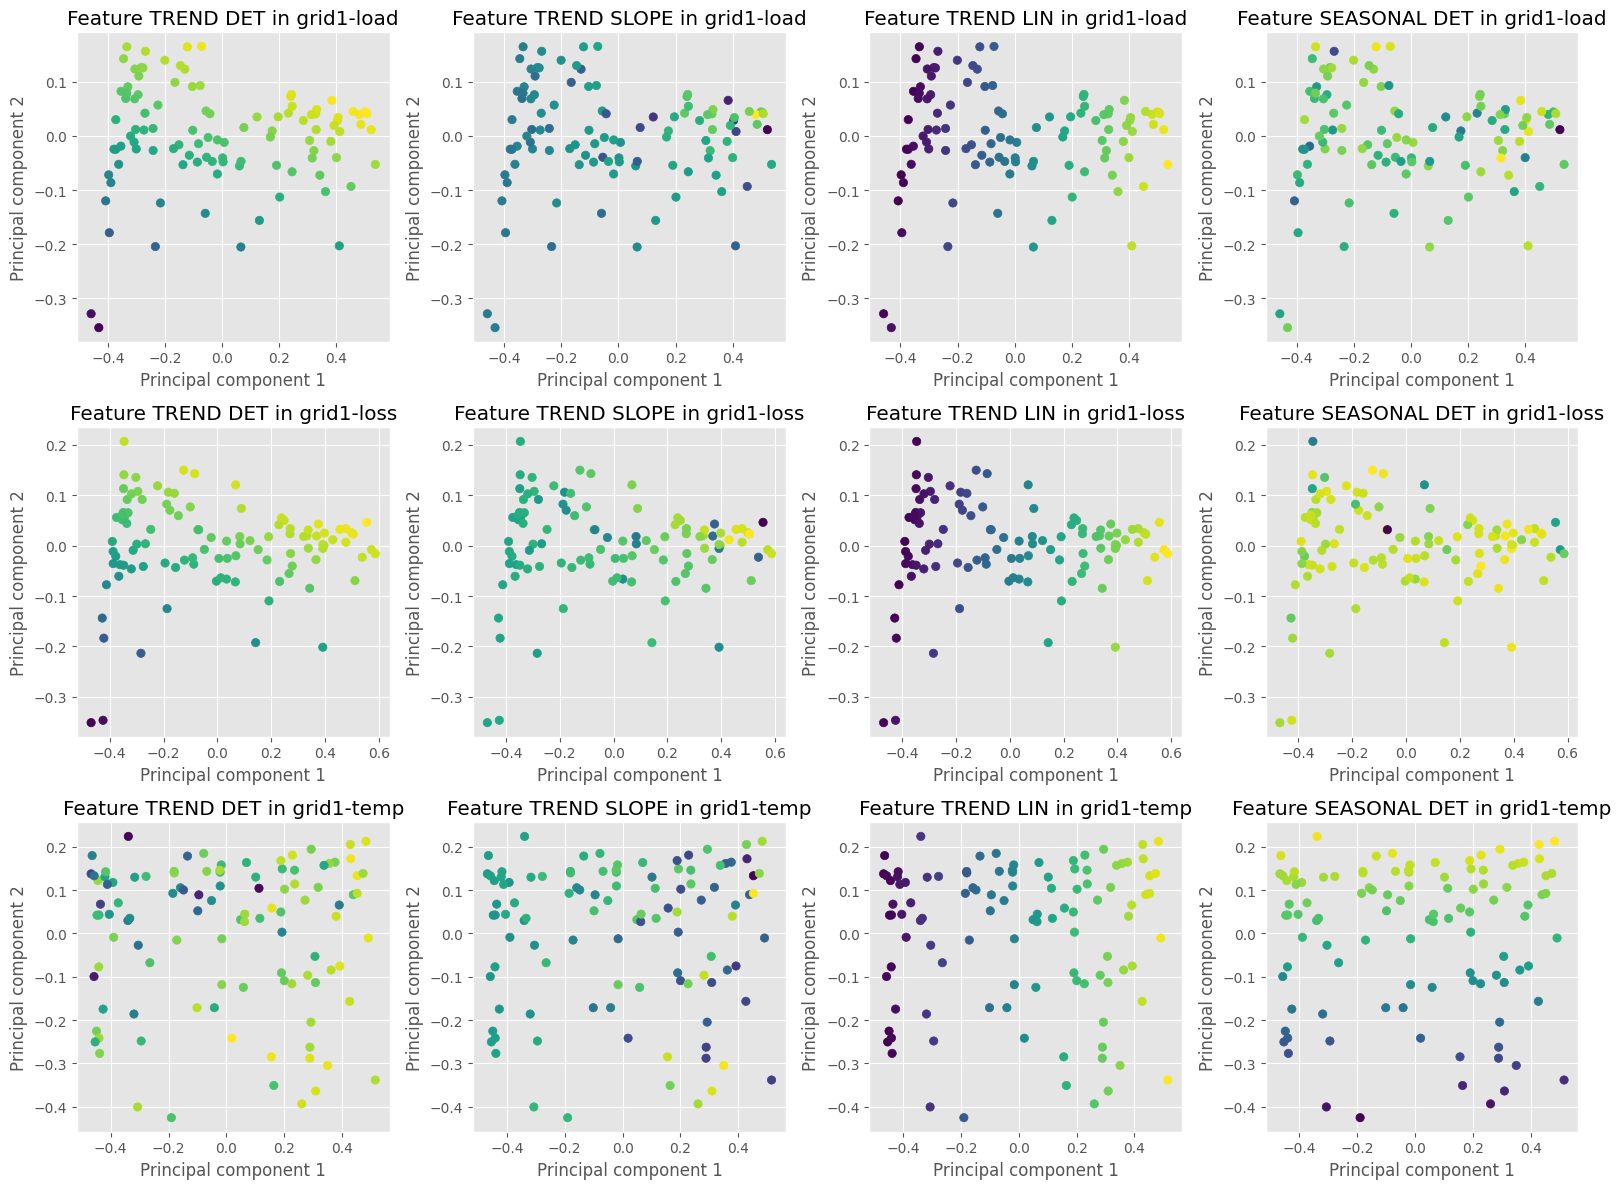

In [34]:
plot_feature_gradient_color(mts_pca, mts_features_reshape, uts_pca_list)

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=10)
mts_tsne = tsne.fit_transform(mts_features_reshape)

uts_tsne_list = [tsne.fit_transform(uts_features_reshape) for uts_features_reshape in [ts1_features_reshape, ts2_features_reshape, ts3_features_reshape]]

C:\Users\hansj\AppData\Local\Temp\ipykernel_11160\3405413561.py:17: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



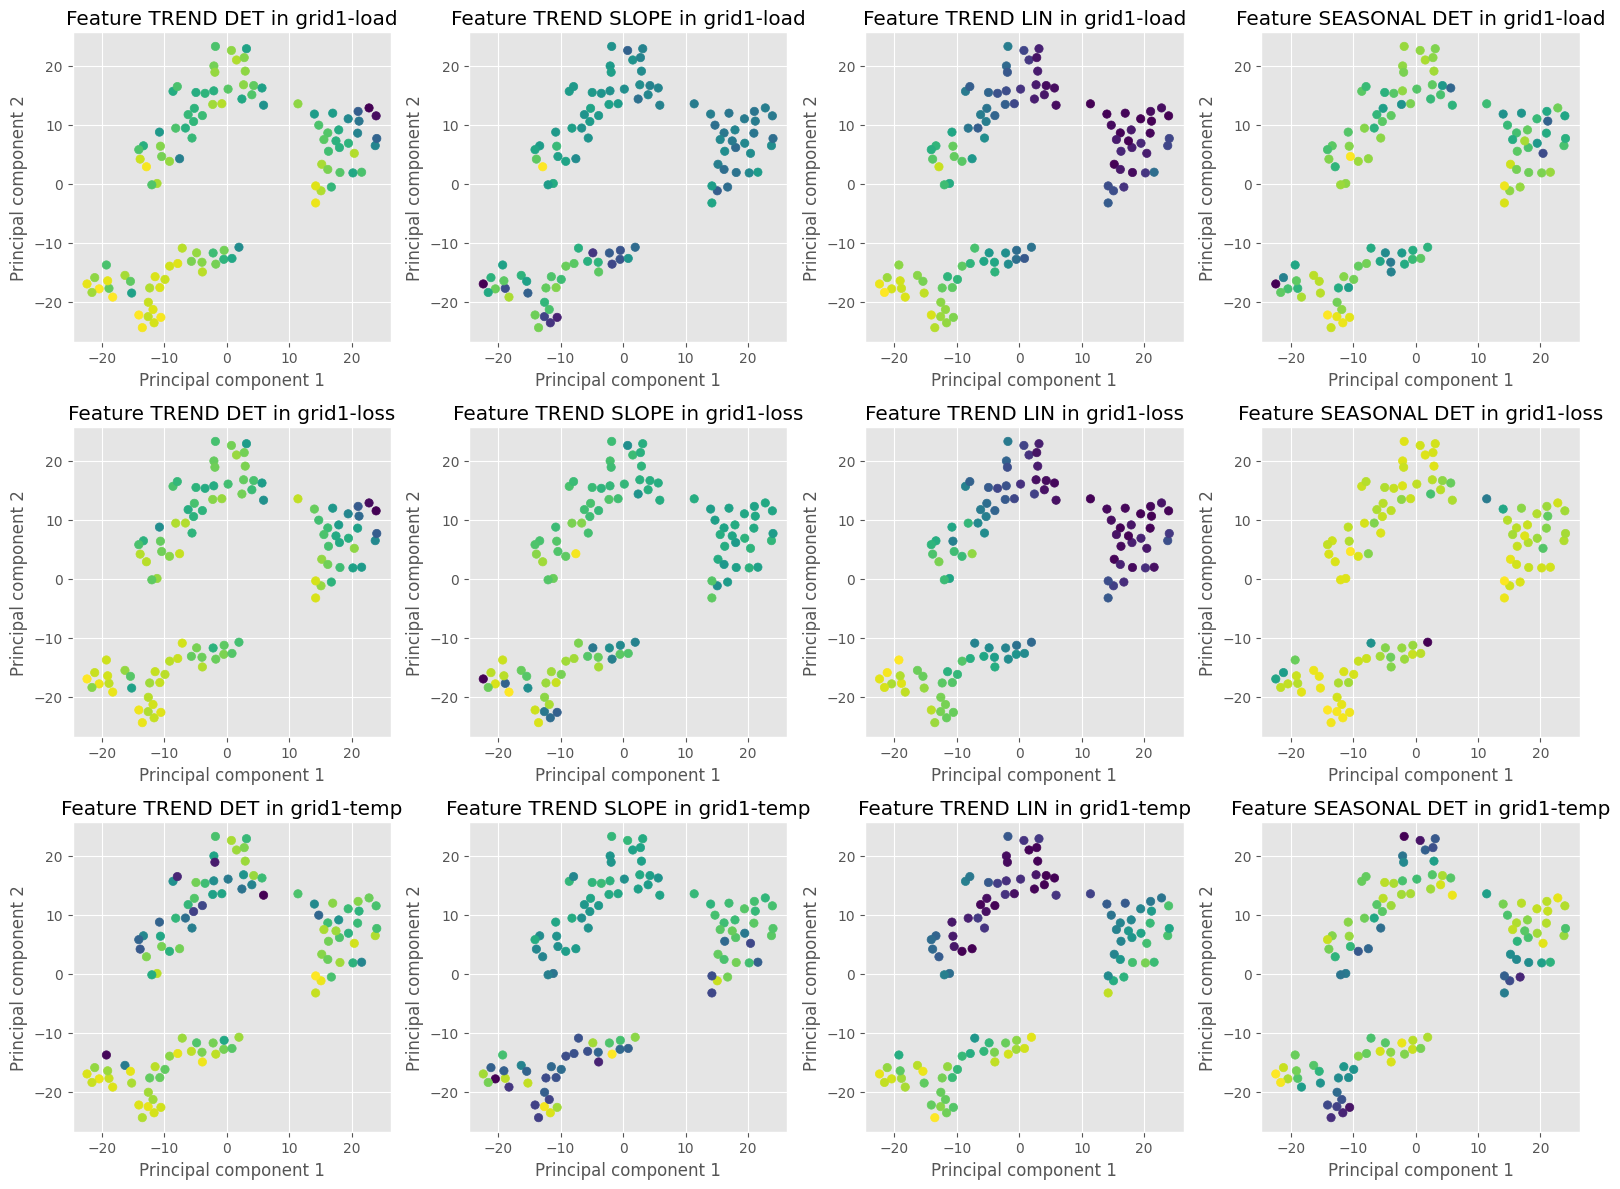

In [36]:
plot_feature_gradient_color(mts_tsne, mts_features_reshape, uts_tsne_list, is_mts=True)

C:\Users\hansj\AppData\Local\Temp\ipykernel_11160\3405413561.py:17: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



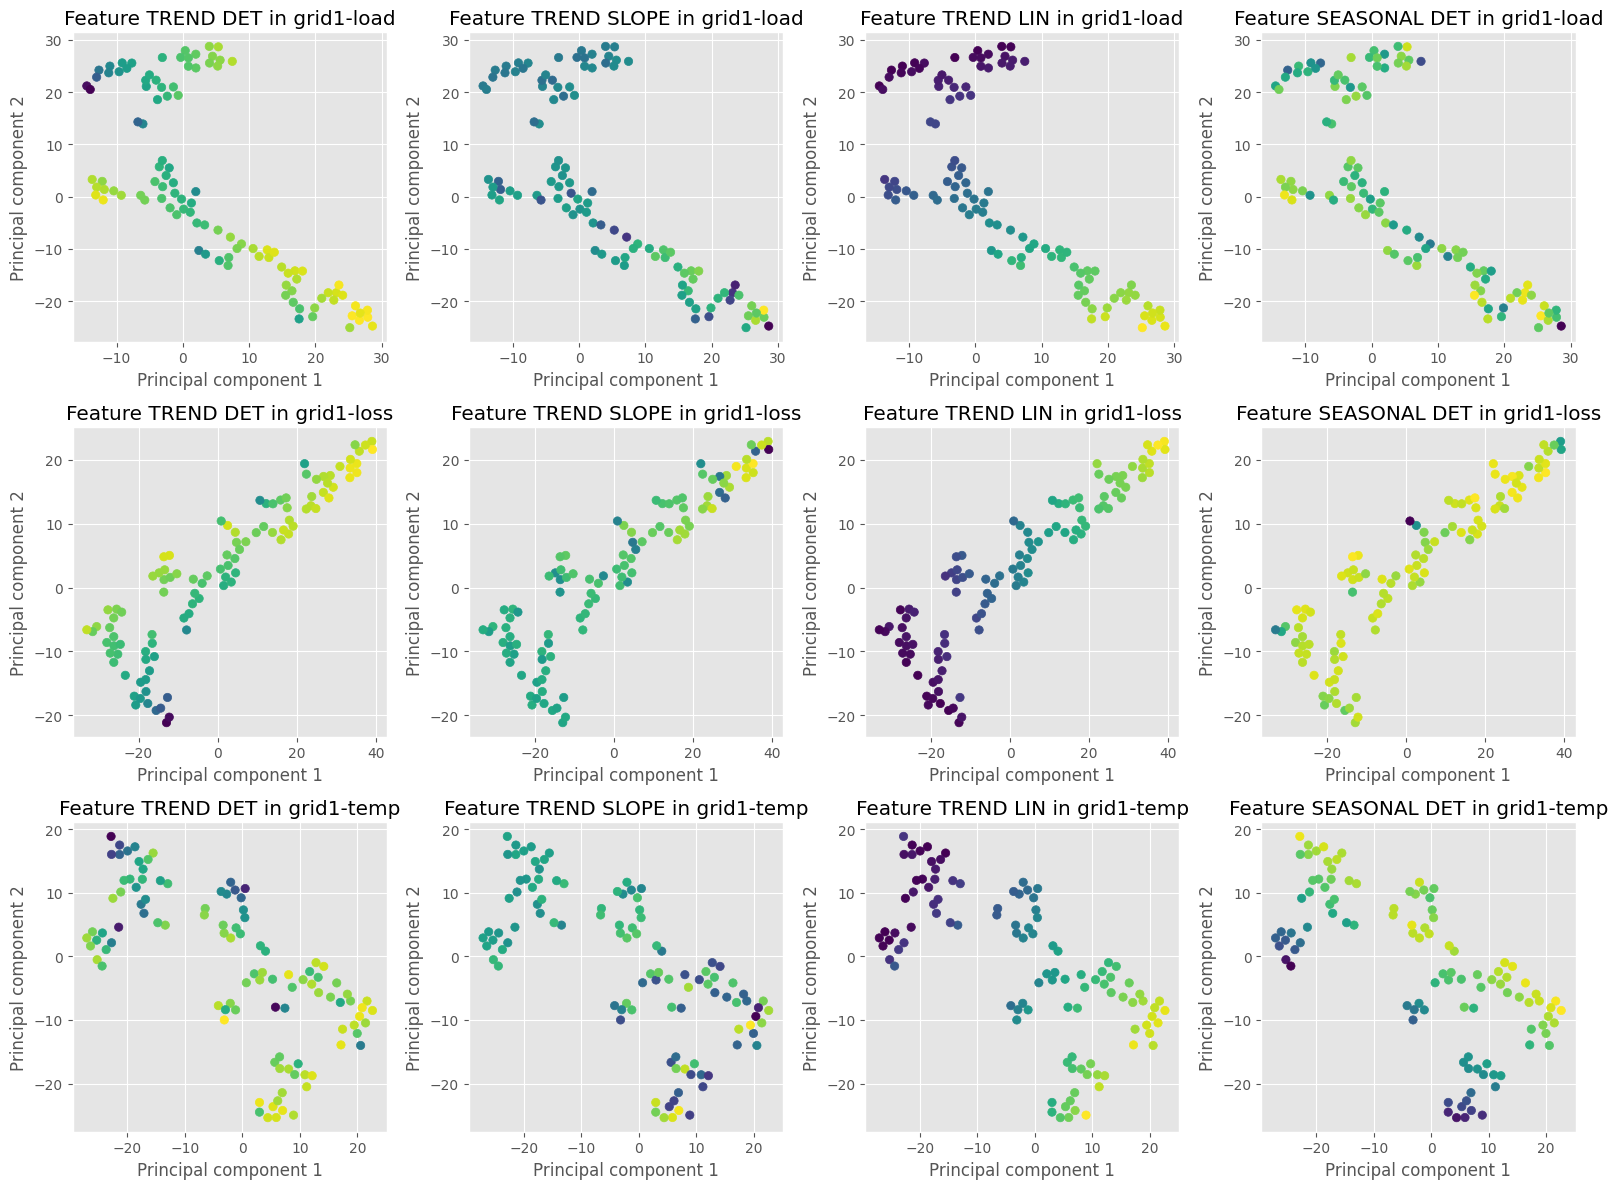

In [37]:
plot_feature_gradient_color(mts_tsne, mts_features_reshape, uts_tsne_list)

In [38]:
from umap import UMAP

umap = UMAP(n_components=2, random_state=0, n_neighbors=40)
mts_umap = umap.fit_transform(mts_features_reshape)

uts_umap_list = [umap.fit_transform(uts_features_reshape) for uts_features_reshape in [ts1_features_reshape, ts2_features_reshape, ts3_features_reshape]]

c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\hans

C:\Users\hansj\AppData\Local\Temp\ipykernel_11160\3405413561.py:17: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



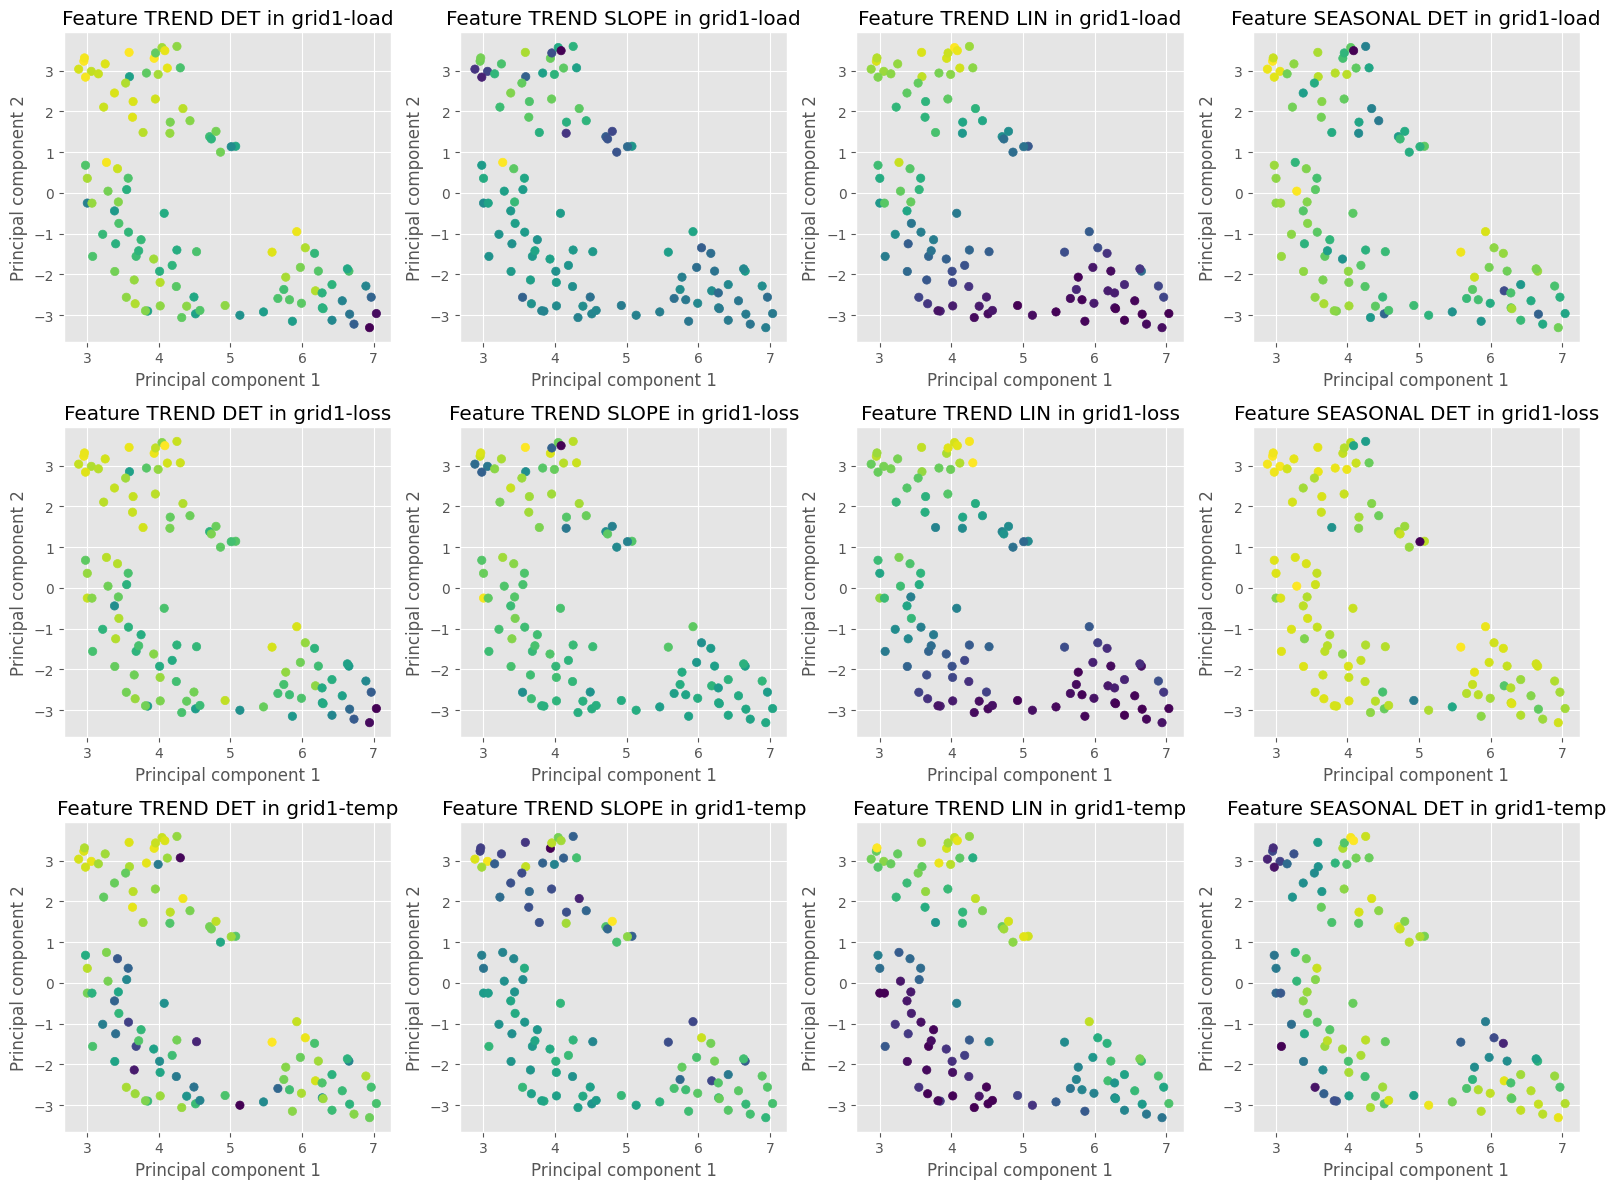

In [39]:
plot_feature_gradient_color(mts_umap, mts_features_reshape, uts_umap_list, is_mts=True)

C:\Users\hansj\AppData\Local\Temp\ipykernel_11160\3405413561.py:17: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



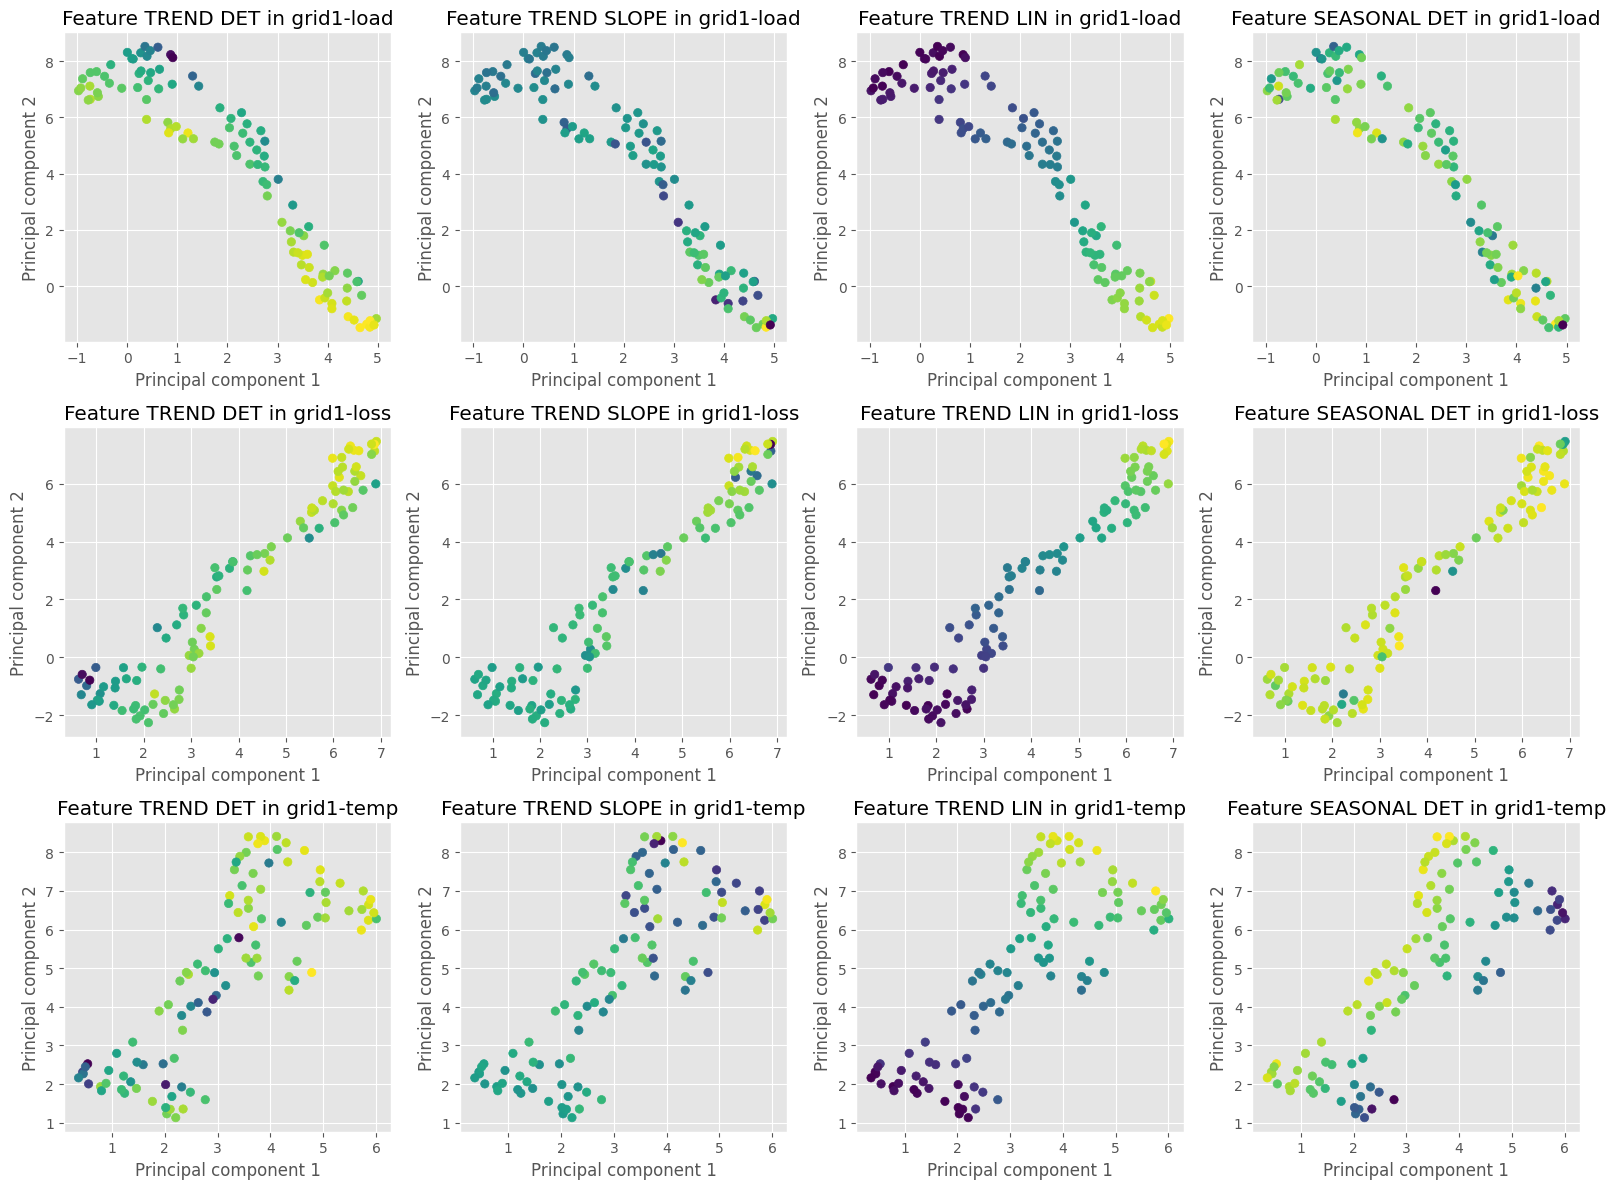

In [40]:
plot_feature_gradient_color(mts_umap, mts_features_reshape, uts_umap_list)